In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras import regularizers

from keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from keras.applications import MobileNet, VGG19
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.python.keras.optimizer_v1 import SGD
from keras.activations import relu, tanh, sigmoid

from sklearn.metrics import confusion_matrix

# IMAGE PREPROCESSING WITH KERAS

In [2]:
import cv2
import imghdr

In [3]:
data_dir = "C:\\Users\\farha\\Desktop\\Py\\Pencil shading"

In [4]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [5]:
os.listdir("C:\\Users\\farha\\Desktop\\Py\\Pencil shading")

['Crayons', 'Oil Pastel', 'Outline', 'Painting', 'Pencil shading']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

# LOAD DATA

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
data = tf.keras.utils.image_dataset_from_directory("C:\\Users\\farha\\Desktop\\Py\\Pencil shading")

Found 3061 files belonging to 5 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

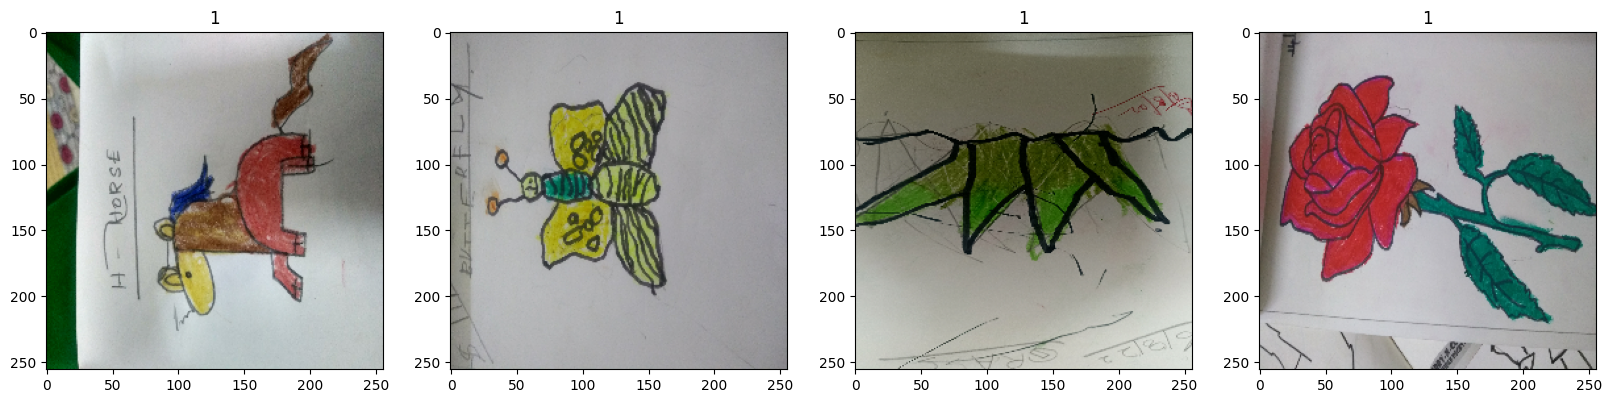

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [13]:
data.as_numpy_iterator().next()

(array([[[[6.31433800e-02, 8.45435038e-02, 9.71660540e-02],
          [8.81280601e-02, 1.03814341e-01, 1.15579046e-01],
          [6.42922819e-02, 8.39001238e-02, 9.95863974e-02],
          ...,
          [6.82490826e-01, 6.78569257e-01, 6.62882984e-01],
          [7.00643361e-01, 6.92800224e-01, 6.96721792e-01],
          [6.97150707e-01, 6.81464434e-01, 6.77542865e-01]],
 
         [[4.37499993e-02, 6.33578449e-02, 7.51225501e-02],
          [7.16299042e-02, 8.73161778e-02, 9.90808830e-02],
          [7.47089460e-02, 9.82383564e-02, 9.82383564e-02],
          ...,
          [6.86014116e-01, 6.86871946e-01, 6.76455259e-01],
          [6.92018986e-01, 6.88097417e-01, 6.80254281e-01],
          [6.82935059e-01, 6.75091922e-01, 6.86856627e-01]],
 
         [[8.16789195e-02, 9.34436247e-02, 1.13051474e-01],
          [6.59773275e-02, 8.16636011e-02, 9.34283063e-02],
          [3.87254916e-02, 5.44117652e-02, 6.61764741e-02],
          ...,
          [6.85294092e-01, 6.85294092e-01, 6.7745

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import img_to_array, array_to_img, load_img
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

directory = "C:\\Users\\farha\\Desktop\\Py\\Pencil shading"

data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(256, 256), 
        batch_size = 2500) 

Found 3061 images belonging to 5 classes.


In [18]:
data_test = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(256, 256), 
        batch_size = 400) 

Found 3061 images belonging to 5 classes.


In [19]:
x_test, y_test = next(data_test)
images, labels = next(data_all)     

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

# TEST MODEL 
# Model 1: VGG19 + 3 Dense Layers (tanh) + SGD

In [21]:

base_model=VGG19(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='tanh')(x)
x=Dense(512,activation='tanh')(x)
x=Dense(100, activation = 'tanh')(x)
preds = Dense(5, activation='softmax')(x)

In [22]:
model=Model(inputs=base_model.input,outputs=preds)

In [23]:
for layer in model.layers[:22]:
    layer.trainable=False
for layer in model.layers[22:]:
    layer.trainable=True

In [24]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# TRAIN THE MODEL

In [26]:
model=Model(inputs=base_model.input,outputs=preds)

In [27]:
for layer in model.layers[:22]:
    layer.trainable=False
for layer in model.layers[22:]:
    layer.trainable=True

In [28]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['acc'])

In [29]:
results = model.fit(x_train, y_train, epochs=25, batch_size=8, validation_data=(x_val, y_val))

Epoch 1/25
250/250 [==============================] - 38s 112ms/step - loss: 1.0035 - acc: 0.6465 - val_loss: 0.7485 - val_acc: 0.7400
Epoch 2/25
250/250 [==============================] - 27s 106ms/step - loss: 0.7423 - acc: 0.7310 - val_loss: 0.6900 - val_acc: 0.7480
Epoch 3/25
250/250 [==============================] - 27s 107ms/step - loss: 0.6725 - acc: 0.7605 - val_loss: 0.6059 - val_acc: 0.7840
Epoch 4/25
250/250 [==============================] - 27s 109ms/step - loss: 0.6444 - acc: 0.7810 - val_loss: 0.5827 - val_acc: 0.8040
Epoch 5/25
250/250 [==============================] - 27s 107ms/step - loss: 0.6249 - acc: 0.7880 - val_loss: 0.6061 - val_acc: 0.7800
Epoch 6/25
250/250 [==============================] - 26s 106ms/step - loss: 0.6085 - acc: 0.7910 - val_loss: 0.5867 - val_acc: 0.7880
Epoch 7/25
250/250 [==============================] - 26s 106ms/step - loss: 0.5834 - acc: 0.8055 - val_loss: 0.5702 - val_acc: 0.7920
Epoch 8/25
250/250 [==============================] - 2

In [30]:
model.save('my_model.h5')